<a href="https://colab.research.google.com/github/DataChemE/generative-opthalmology/blob/main/opthalmologic_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from PIL import Image
import torchvision

# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [2]:
# Connect google drive to colab for training on the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Google Drive base directory
BASE_DIR = '/content/drive/MyDrive/'

# Local Base Directory
# BASE_DIR = './'

# Define the path to the fundus photos

# Local image path
#IMAGE_PATH = '/Volumes/Extreme SSD/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.0/fundus_photos/'

# Google drive image path
IMAGE_PATH = '/content/drive/MyDrive/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.0/fundus_photos/'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
BATCH_SIZE = 64
NUM_WORKERS = 2
IMAGE_SIZE = 64
nz = 100
ndf = 64
ngf = 64
num_epochs = 100
lr = 0.0002
beta1 = 0.5
ngpu = 1

In [15]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import logging

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.images = []
        for f in os.listdir(img_dir):
            if f.lower().endswith(('.png', '.jpg', '.jpeg')) and not f.startswith('._'):
                self.images.append(f)
        logging.info(f"Found {len(self.images)} valid image files.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
        except (IOError, OSError) as e:
            logging.error(f"Error opening image {img_path}: {e}")
            # Return a blank image or skip this image
            image = Image.new('RGB', (224, 224), color='black')

        if self.transform:
            image = self.transform(image)

        return image

# Set up logging
logging.basicConfig(level=logging.INFO)

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


dataset = CustomImageDataset(img_dir=IMAGE_PATH, transform=transform)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)


torch.Size([64, 3, 64, 64])


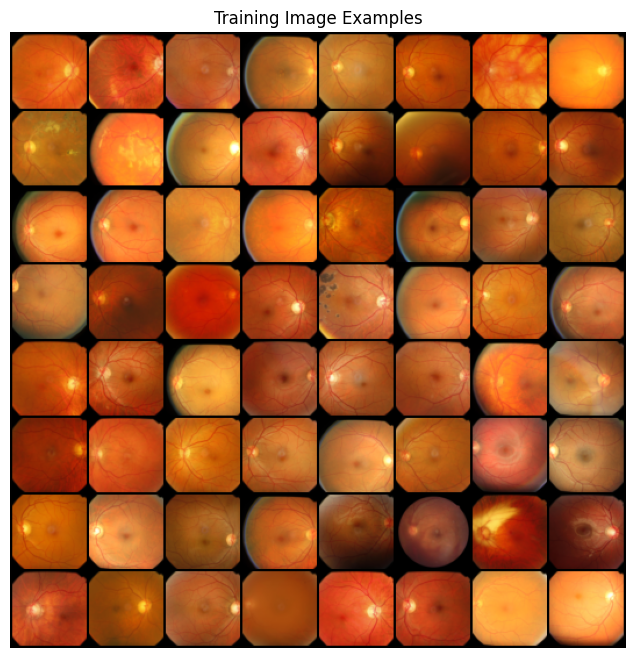

In [19]:
# Plot images examples
def plot_images(dataloader):
    batch_example = next(iter(dataloader))
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Training Image Examples")

    # only plot 64 images or less
    num_images = min(64, batch_example.size(0))

    grid = torchvision.utils.make_grid(batch_example[:num_images], padding=2, normalize=True)
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.show()

plot_images(dataloader)